In [15]:
import collections

import hetmatpy.hetmat
import matplotlib.pyplot as plt
import networkx as nx
import networkx.algorithms.bipartite as bip
import numpy as np
import pandas as pd
import scipy.sparse
import tqdm
import xswap

%matplotlib inline

In [2]:
def edges_to_mat(edges, shape=None):
    if shape is None:
        n = max(map(max, edges)) + 1
        shape=(n, n)
    return scipy.sparse.coo_matrix((np.ones(len(edges)), (zip(*edges))), shape=shape).toarray()

def mat_to_edges(mat):
    sp = scipy.sparse.coo_matrix(mat)
    edges = sorted(set(map(tuple, map(sorted, zip(sp.row, sp.col)))))
    return edges

In [3]:
hetmat = hetmatpy.hetmat.HetMat('../../data/ppi_hetmat/')
_, _, mat = hetmat.metaedge_to_adjacency_matrix('PiP', dense_threshold=0)
mat -= np.diag(mat.diagonal())
mat = mat.astype(int)

edges = mat_to_edges(mat)
true_degrees = mat.sum(axis=1)
max_degree = true_degrees.max()

# XSwap
permuted_edges, _ = xswap.permute_edge_list(edges)
permuted_mat = edges_to_mat(permuted_edges, shape=mat.shape)

# Havel-Hakimi
hh = bip.havel_hakimi_graph(true_degrees, true_degrees, create_using=nx.Graph())
hh_mat = nx.adjacency_matrix(hh).toarray()
hh_mat = hh_mat[len(true_degrees):, :len(true_degrees)]
hh_graph = nx.from_numpy_array(hh_mat)

# Permutation of Havel-Hakimi
swapped_havel, _ = xswap.permute_edge_list(list(hh_graph.edges))
swapped_havel_mat = edges_to_mat(swapped_havel, shape=mat.shape)
swapped_hh_graph = nx.from_numpy_array(swapped_havel_mat)

graphs = {
    'true': nx.from_numpy_array(mat),
    'configuration_model': nx.configuration_model(true_degrees),
    'expected-degree': nx.expected_degree_graph(true_degrees, selfloops=False),
    'erdos-renyi': nx.erdos_renyi_graph(mat.shape[0], mat.sum() / np.prod(mat.shape)),
    'permuted': nx.from_numpy_array(permuted_mat),
    'havel-hakimi': hh_graph,
    'swapped-hh': swapped_hh_graph,
}

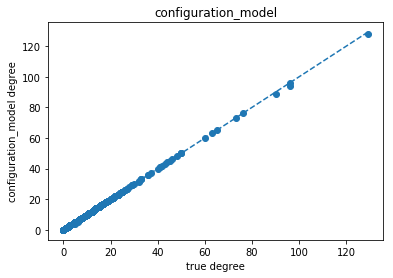

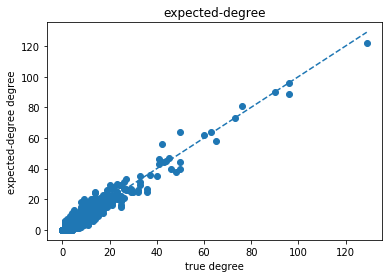

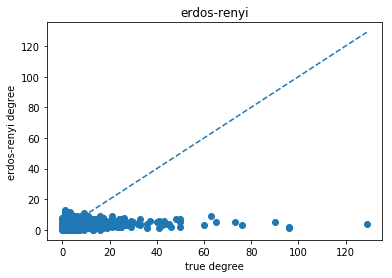

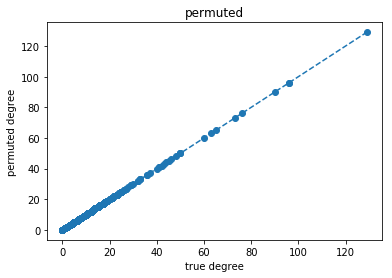

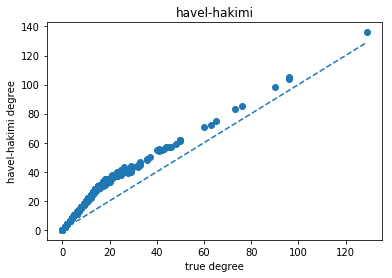

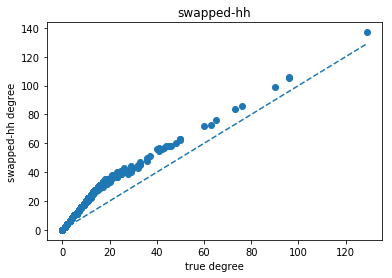

In [4]:
for k, v in graphs.items():
    if k == 'true':
        continue
    true = nx.adjacency_matrix(graphs['true']).sum(axis=1).A.flatten()
    random = nx.adjacency_matrix(v).sum(axis=1).A.flatten()
    plt.figure()
    plt.title(k)
    plt.scatter(true, random)
    plt.plot([0, max_degree], [0, max_degree], linestyle='--')
    plt.xlabel('true degree')
    plt.ylabel(f'{k} degree')

<BarContainer object of 7 artists>

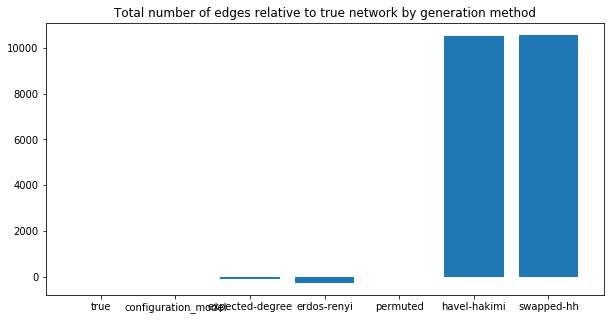

In [5]:
num_edges = {k: nx.adjacency_matrix(v).sum() for k, v in graphs.items()}
num_edges = {k: v - num_edges['true'] for k, v in num_edges.items()}
plt.figure(figsize=(12,5))
plt.title('Total number of edges relative to true network by generation method')
plt.bar(range(len(num_edges)), list(num_edges.values()), tick_label=list(num_edges.keys()))

<BarContainer object of 6 artists>

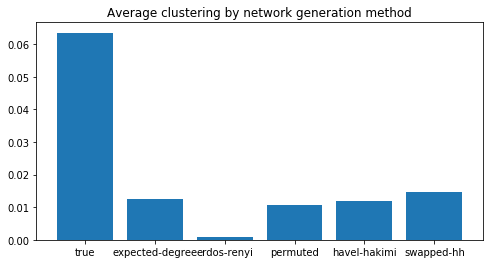

In [6]:
clustering = {k: nx.average_clustering(v) for k, v in graphs.items() if k != 'configuration_model'}
plt.figure(figsize=(10,4))
plt.title('Average clustering by network generation method')
plt.bar(range(len(clustering)), list(clustering.values()), tick_label=list(clustering.keys()))

<BarContainer object of 6 artists>

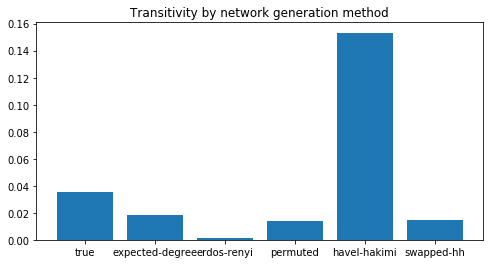

In [7]:
clustering = {k: nx.transitivity(v) for k, v in graphs.items() if k != 'configuration_model'}
plt.figure(figsize=(10, 4))
plt.title('Transitivity by network generation method')
plt.bar(range(len(clustering)), list(clustering.values()), tick_label=list(clustering.keys()))

<BarContainer object of 6 artists>

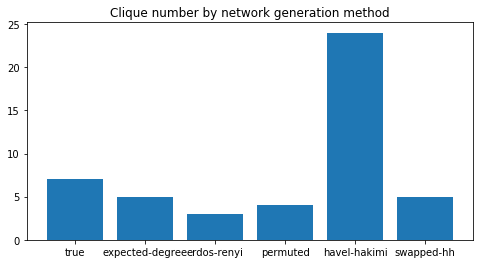

In [8]:
clustering = {k: nx.graph_clique_number(v) for k, v in graphs.items() if k != 'configuration_model'}
plt.figure(figsize=(10, 4))
plt.title('Clique number by network generation method')
plt.bar(range(len(clustering)), list(clustering.values()), tick_label=list(clustering.keys()))

<BarContainer object of 6 artists>

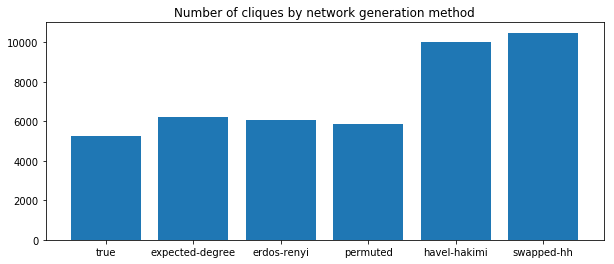

In [12]:
clustering = {k: nx.graph_number_of_cliques(v) for k, v in graphs.items() if k != 'configuration_model'}
plt.figure(figsize=(10, 4))
plt.title('Number of cliques by network generation method')
plt.bar(range(len(clustering)), list(clustering.values()), tick_label=list(clustering.keys()))

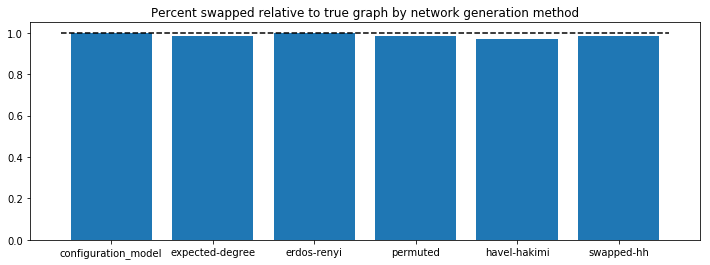

In [11]:
def percent_swapped(graph):
    edges_set = set(graph.edges)
    true_set = set(edges)
    return 1 - len(true_set.intersection(edges_set)) / len(true_set)
    

clustering = {k: percent_swapped(v) for k, v in graphs.items() if k != 'true'}
plt.figure(figsize=(12, 4))
plt.title('Percent swapped relative to true graph by network generation method')
plt.bar(range(len(clustering)), list(clustering.values()), tick_label=list(clustering.keys()))
plt.plot([-0.5, len(clustering) - 0.5], [1, 1], color='black', linestyle='--')